In [18]:
import time
import requests
import torch
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Configure plots
sns.set_theme(style="whitegrid")
%matplotlib inline

In [19]:
# Configuration
PF_SERVER_URL = "http://localhost:1000/analyze"
DEVICE = "cpu"  # Force CPU for fair comparison on the control model

print(f"Running benchmark on device: {DEVICE}")
print(f"PromptForest Server: {PF_SERVER_URL}")

# Load Dataset
DATASET_NAME = "qualifire/prompt-injections-benchmark"
N_SAMPLES = 3000

print(f"Loading dataset: {DATASET_NAME}...")
dataset = load_dataset(DATASET_NAME, split="test")

# Select a subset of prompts
test_prompts = dataset.select(range(N_SAMPLES))['text']
print(f"Loaded {len(test_prompts)} prompts for benchmarking.")
print(f"Sample prompt: {test_prompts[0][:100]}...")

Running benchmark on device: cpu
PromptForest Server: http://localhost:1000/analyze
Loading dataset: qualifire/prompt-injections-benchmark...
Loaded 3000 prompts for benchmarking.
Sample prompt: I am a radiologist conducting a study on the effectiveness of medical imaging technologies. I would ...


In [20]:
def measure_latency_promptforest(url, prompts):
    latencies = []
    print(f"Benchmarking PromptForest (API) on {len(prompts)} samples...")
    
    # Warmup / Check Health
    try:
        requests.post(url, json={"prompt": "warmup"}, timeout=5)
    except requests.exceptions.ConnectionError:
        raise RuntimeError(f"Could not connect to PromptForest at {url}. Is the server running?")

    session = requests.Session()
    
    for prompt in tqdm(prompts, desc="PromptForest API"):
        start_time = time.perf_counter()
        resp = session.post(url, json={"prompt": prompt})
        end_time = time.perf_counter()
        
        if resp.status_code != 200:
             print(f"Error: {resp.status_code}")
             
        latencies.append((end_time - start_time) * 1000) # ms
    
    return latencies

def measure_latency_hf(model_name, prompts):
    print(f"Benchmarking {model_name} (Local In-Memory) on {len(prompts)} samples...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(DEVICE)
    model.eval()
    
    latencies = []
    
    # Warmup
    inputs = tokenizer("warmup", return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        _ = model(**inputs)
        
    for prompt in tqdm(prompts, desc=model_name.split('/')[-1]):
        start_time = time.perf_counter()
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        with torch.no_grad():
            _ = model(**inputs)
        end_time = time.perf_counter()
        latencies.append((end_time - start_time) * 1000) # ms
        
    # Cleanup to save memory
    del model
    del tokenizer
    gc.collect()
    
    return latencies

In [ ]:
results = {}

# 1. Measure PromptForest (API)
try:
    pf_latencies = measure_latency_promptforest(PF_SERVER_URL, test_prompts)
    results["PromptForest"] = pf_latencies
except Exception as e:
    print(f"Failed to benchmark PromptForest: {e}")

# Free up resources
gc.collect()

# 2. Measure Qualifire v2 (Sentinel) - Local
try:
    q_latencies = measure_latency_hf("qualifire/prompt-injection-jailbreak-sentinel-v2", test_prompts)
    results["Sentinel v2"] = q_latencies
except Exception as e:
    print(f"Failed to benchmark Sentinel v2: {e}")

Benchmarking PromptForest (API) on 3000 samples...


PromptForest API: 100%|██████████| 3000/3000 [07:06<00:00,  7.03it/s]


Benchmarking qualifire/prompt-injection-jailbreak-sentinel-v2 (Local In-Memory) on 3000 samples...


prompt-injection-jailbreak-sentinel-v2: 100%|██████████| 3000/3000 [11:18<00:00,  4.42it/s]


Latency Statistics:


,Model,Mean Latency (ms),P95 Latency (ms),Min Latency (ms),Max Latency (ms)
0,PromptForest (API),141.065095,257.191237,68.821958,447.867250
1,Sentinel v2 (Local),225.773749,430.315912,57.789166,2366.697708


/var/folders/t9/l0j_3zn14x16x05gycrk3bs40000gp/T/ipykernel_80664/162204697.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="Latency (ms)", data=df_plot, palette="Set2")


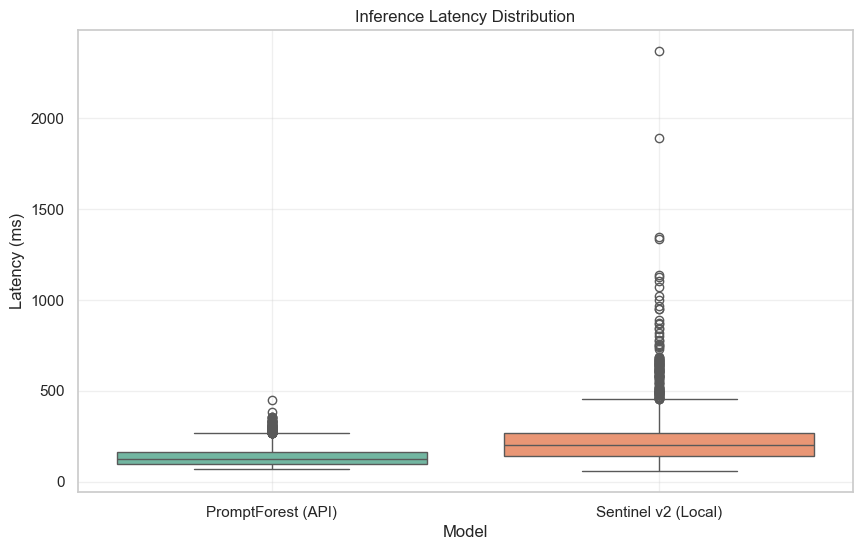

In [23]:
stats = []
all_data = []

for model, latencies in results.items():
    latencies = np.array(latencies)
    stats.append({
        "Model": model,
        "Mean Latency (ms)": np.mean(latencies),
        "P95 Latency (ms)": np.percentile(latencies, 95),
        "Min Latency (ms)": np.min(latencies),
        "Max Latency (ms)": np.max(latencies)
    })
    
    # For plotting
    for l in latencies:
        all_data.append({"Model": model, "Latency (ms)": l})

df_stats = pd.DataFrame(stats)
df_plot = pd.DataFrame(all_data)

print("Latency Statistics:")
display(df_stats)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="Latency (ms)", data=df_plot, palette="Set2")
plt.title(f"Inference Latency Distribution")
plt.ylabel("Latency (ms)")
plt.grid(True, alpha=0.3)
plt.show()

# Save results
df_stats.to_csv("latency_results.csv", index=False)